In [2]:
import wrds
import numpy as np
import pandas as pd

conn = wrds.Connection(wrds_username='jackw')

Loading library list...
Done


In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import gmean
from matplotlib import pyplot as plt
import riskfolio as rp

input_portfolio = ["NVDA", "AAPL", "MSFT", "LUV", "AMZN", "MET", "AMD", "SPG", "EQIX", "APD", "CRH", "CVX", "REGN", "VRTX", "SBAC", "ORLY", "DAL", "ETN", "INTC", "SO", "DUK", "NOC", "PCAR", "FITB", "EBAY"]
portfolio = sorted(input_portfolio)

def training_data_retrieval(portfolio):
    portfolio_data = conn.raw_sql("""select ticker, mthcaldt, mthret 
                            from crsp_a_stock.wrds_msfv2_query 
                            where mthcaldt>='01/01/2019'
                            and mthcaldt<= '12/31/2020'""", 
                         date_cols=['mthcaldt'])
    portfolio_data = portfolio_data[portfolio_data.ticker.isin(portfolio) == True]
    portfolio_df = portfolio_data.pivot_table(index='mthcaldt', columns='ticker', values='mthret', aggfunc='mean')
    return portfolio_df

training_returns = training_data_retrieval(portfolio)

def testing_data_retrieval(portfolio):
    portfolio_data = conn.raw_sql("""select ticker, mthcaldt, mthret 
                            from crsp_a_stock.wrds_msfv2_query 
                            where mthcaldt>='01/01/2021'
                            and mthcaldt<= '12/31/2021'""", 
                         date_cols=['mthcaldt'])
    portfolio_data = portfolio_data[portfolio_data.ticker.isin(portfolio) == True]
    portfolio_df = portfolio_data.pivot_table(index='mthcaldt', columns='ticker', values='mthret', aggfunc='mean')
    return portfolio_df

testing_returns = testing_data_retrieval(portfolio)

In [4]:
def plot_dendrogram(portfolio):
    '''
    Plots dendrogram depicting clusters and the distances, representing the similarities
    '''
    ax = rp.plot_dendrogram(returns=training_returns, codependence='distance', linkage='ward')
    return ax

def hrp_allocation(portfolio):
    '''
    Uses inverse variation to allocate weights to each stock based on its cluster's variance
    '''
    port = rp.HCPortfolio(returns=training_returns)
    hrp_weights = port.optimization(model="HRP", codependence="distance", rm="MV", linkage="ward")
    return hrp_weights

def equal_allocation(portfolio):
    '''
    Creates a list of equal allocations based on the number of stocks in the portfolio
    '''
    equal_allocations = []
    for stock in range(len(portfolio)):
        equal_allocations.append( 1 / len(portfolio))
    return equal_allocations

def minimum_variance_allocation(portfolio):
    port = rp.Portfolio(returns=training_returns)
    port.assets_stats(method_mu="hist", method_cov="hist")
    minimum_variance_weights = port.optimization(model="Classic", rm="MV", obj="MinRisk")
    return minimum_variance_weights

def mean_variance_optimal_allocation(portfolio):
    port = rp.Portfolio(returns=training_returns)
    port.assets_stats(method_mu="hist", method_cov="hist")
    mean_variance_optimal_weights = port.optimization(model="Classic", rm="MV", obj="Sharpe")
    return mean_variance_optimal_weights

def gmean_return(portfolio_df):
    '''
    Calculates geometric mean return for each stock in the portfolio
    '''
    gmean_return = 0
    portfolio_df = portfolio_df + 1
    gmean_return = gmean(portfolio_df)
    gmean_return = gmean_return - 1
    return gmean_return

In [5]:
# HRP Testing

def hrp_training_return(portfolio):
    '''
    Uses geometric mean returns of each stock to determine overall return of portfolio based on allocations
    '''
    gmean_returns = gmean_return(training_returns)
    hrp_return = np.dot(gmean_returns, hrp_allocation(portfolio))
    return hrp_return

def hrp_training_risk(portfolio):
    '''
    Uses covariances and allocations to determine the risk of the HRP portfolio
    '''
    cov_matrix = training_returns.cov()
    risk = np.sqrt(np.dot(hrp_allocation(portfolio).T, np.dot(cov_matrix,hrp_allocation(portfolio))))
    stddev_lol = risk.tolist()
    stddev_l = [i[0] for i in stddev_lol]
    stddev = float(stddev_l[0])
    return stddev

def hrp_testing_return(portfolio):
    '''
    Uses geometric mean returns of each stock to determine overall return of portfolio based on allocations
    '''
    gmean_returns = gmean_return(testing_returns)
    hrp_return = np.dot(gmean_returns, hrp_allocation(portfolio))
    return hrp_return

def hrp_testing_risk(portfolio):
    '''
    Uses covariances and allocations to determine the risk of the HRP portfolio
    '''
    cov_matrix = testing_returns.cov()
    risk = np.sqrt(np.dot(hrp_allocation(portfolio).T, np.dot(cov_matrix,hrp_allocation(portfolio))))
    stddev_lol = risk.tolist()
    stddev_l = [i[0] for i in stddev_lol]
    stddev = float(stddev_l[0])
    return stddev

def hrp_cumulative_return_testing(portfolio):
    '''
    Calculates HRP portfolio's cumulative return for testing period
    '''
    cumulative_return = 1
    portfolio_df = testing_returns
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(hrp_allocation(portfolio).T, date_returns))
    cumulative_return = (cumulative_return - 1)
    return cumulative_return

def hrp_return_testing_list(portfolio):
    portfolio_df = testing_returns
    monthly_returns = []
    cumulative_return = 1
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(hrp_allocation(portfolio).T, date_returns))
        monthly_returns.append(cumulative_return - 1)
    return monthly_returns

def hrp_cumulative_return_training(portfolio):
    '''
    Calculates HRP portfolio's cumulative return for training period
    '''
    cumulative_return = 1
    portfolio_df = training_returns
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(hrp_allocation(portfolio).T, date_returns))
    cumulative_return = (cumulative_return - 1)
    return cumulative_return

def hrp_return_training_list(portfolio):
    portfolio_df = training_returns
    monthly_returns = []
    cumulative_return = 1
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(hrp_allocation(portfolio).T, date_returns))
        monthly_returns.append(cumulative_return - 1)
    return monthly_returns

# Minimum-Variance Testing

def mv_training_return(portfolio):
    '''
    Uses geometric mean returns of each stock to determine overall return of portfolio based on allocations
    '''
    gmean_returns = gmean_return(training_returns)
    mv_return = np.dot(gmean_returns, minimum_variance_allocation(portfolio))
    return mv_return

def mv_training_risk(portfolio):
    '''
    Uses covariances and allocations to determine the risk of the Minimum-Variance portfolio
    '''
    cov_matrix = training_returns.cov()
    risk = np.sqrt(np.dot(minimum_variance_allocation(portfolio).T, np.dot(cov_matrix,minimum_variance_allocation(portfolio))))
    stddev_lol = risk.tolist()
    stddev_l = [i[0] for i in stddev_lol]
    stddev = float(stddev_l[0])
    return stddev

def mv_testing_return(portfolio):
    '''
    Uses geometric mean returns of each stock to determine overall return of portfolio based on allocations
    '''
    gmean_returns = gmean_return(testing_returns)
    mv_return = np.dot(gmean_returns, minimum_variance_allocation(portfolio))
    return mv_return

def mv_testing_risk(portfolio):
    '''
    Uses covariances and allocations to determine the risk of the Minimum-Variance portfolio
    '''
    cov_matrix = testing_returns.cov()
    risk = np.sqrt(np.dot(minimum_variance_allocation(portfolio).T, np.dot(cov_matrix,minimum_variance_allocation(portfolio))))
    stddev_lol = risk.tolist()
    stddev_l = [i[0] for i in stddev_lol]
    stddev = float(stddev_l[0])
    return stddev

def mv_cumulative_return_testing(portfolio):
    '''
    Calculates Minimimum Variance portfolio's cumulative return for testing period
    '''
    cumulative_return = 1
    portfolio_df = testing_returns
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(minimum_variance_allocation(portfolio).T, date_returns))
    cumulative_return = (cumulative_return - 1)
    return cumulative_return

def mv_return_testing_list(portfolio):
    portfolio_df = testing_returns
    monthly_returns = []
    cumulative_return = 1
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(minimum_variance_allocation(portfolio).T, date_returns))
        monthly_returns.append(cumulative_return - 1)
    return monthly_returns

def mv_cumulative_return_training(portfolio):
    '''
    Calculates Minimum Variance portfolio's cumulative return for training period
    '''
    cumulative_return = 1
    portfolio_df = training_returns
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(minimum_variance_allocation(portfolio).T, date_returns))
    cumulative_return = (cumulative_return - 1)
    return cumulative_return

def mv_return_training_list(portfolio):
    portfolio_df = training_returns
    monthly_returns = []
    cumulative_return = 1
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(minimum_variance_allocation(portfolio).T, date_returns))
        monthly_returns.append(cumulative_return - 1)
    return monthly_returns



# Mean-Variance Optimal Testing

def meanv_training_return(portfolio):
    '''
    Uses geometric mean returns of each stock to determine overall return of portfolio based on allocations
    '''
    gmean_returns = gmean_return(training_returns)
    meanv_return = np.dot(gmean_returns, mean_variance_optimal_allocation(portfolio))
    return meanv_return

def meanv_training_risk(portfolio):
    '''
    Uses covariances and allocations to determine the risk of the Minimum-Variance portfolio
    '''
    cov_matrix = training_returns.cov()
    risk = np.sqrt(np.dot(mean_variance_optimal_allocation(portfolio).T, np.dot(cov_matrix,mean_variance_optimal_allocation(portfolio))))
    stddev_lol = risk.tolist()
    stddev_l = [i[0] for i in stddev_lol]
    stddev = float(stddev_l[0])
    return stddev

def meanv_testing_return(portfolio):
    '''
    Uses geometric mean returns of each stock to determine overall return of portfolio based on allocations
    '''
    gmean_returns = gmean_return(testing_returns)
    meanv_return = np.dot(gmean_returns, mean_variance_optimal_allocation(portfolio))
    return meanv_return

def meanv_testing_risk(portfolio):
    '''
    Uses covariances and allocations to determine the risk of the Minimum-Variance portfolio
    '''
    cov_matrix = testing_returns.cov()
    risk = np.sqrt(np.dot(mean_variance_optimal_allocation(portfolio).T, np.dot(cov_matrix,mean_variance_optimal_allocation(portfolio))))
    stddev_lol = risk.tolist()
    stddev_l = [i[0] for i in stddev_lol]
    stddev = float(stddev_l[0])
    return stddev

def meanv_cumulative_return_testing(portfolio):
    '''
    Calculates Minimimum Variance portfolio's cumulative return for testing period
    '''
    cumulative_return = 1
    portfolio_df = testing_returns
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(mean_variance_optimal_allocation(portfolio).T, date_returns))
    cumulative_return = (cumulative_return - 1)
    return cumulative_return

def meanv_return_testing_list(portfolio):
    portfolio_df = testing_returns
    monthly_returns = []
    cumulative_return = 1
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(mean_variance_optimal_allocation(portfolio).T, date_returns))
        monthly_returns.append(cumulative_return - 1)
    return monthly_returns

def meanv_cumulative_return_training(portfolio):
    '''
    Calculates Minimum Variance portfolio's cumulative return for training period
    '''
    cumulative_return = 1
    portfolio_df = training_returns
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(mean_variance_optimal_allocation(portfolio).T, date_returns))
    cumulative_return = (cumulative_return - 1)
    return cumulative_return

def meanv_return_training_list(portfolio):
    portfolio_df = training_returns
    monthly_returns = []
    cumulative_return = 1
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(mean_variance_optimal_allocation(portfolio).T, date_returns))
        monthly_returns.append(cumulative_return - 1)
    return monthly_returns




# Equal-Weight Testing

def equal_training_return(portfolio):
    '''
    Uses geometric mean returns of each stock to determine overall return of portfolio based on equal allocations
    '''
    gmean_returns = gmean_return(training_returns)
    equal_return = np.dot(gmean_returns, equal_allocation(portfolio))
    return equal_return

def equal_training_risk(portfolio):
    '''
    Uses covariances and allocations to determine the risk of the equal-weight portfolio
    '''
    cov_matrix = training_returns.cov()
    risk = np.sqrt(np.dot(equal_allocation(portfolio), np.dot(cov_matrix,equal_allocation(portfolio))))
    stddev = risk.tolist()
    return stddev

def equal_testing_return(portfolio):
    '''
    Uses geometric mean returns of each stock to determine overall return of portfolio based on equal allocations
    '''
    gmean_returns = gmean_return(testing_returns)
    equal_return = np.dot(gmean_returns, equal_allocation(portfolio))
    return equal_return

def equal_testing_risk(portfolio):
    '''
    Uses covariances and allocations to determine the risk of the equal-weight portfolio
    '''
    cov_matrix = testing_returns.cov()
    risk = np.sqrt(np.dot(equal_allocation(portfolio), np.dot(cov_matrix,equal_allocation(portfolio))))
    stddev = risk.tolist()
    return stddev

def equal_cumulative_return_testing(portfolio):
    '''
    Calculates equal-weight portfolio's cumulative return for testing period
    '''
    cumulative_return = 1
    portfolio_df = testing_returns
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(equal_allocation(portfolio), date_returns))
    cumulative_return = (cumulative_return - 1)
    return cumulative_return

def equal_return_testing_list(portfolio):
    portfolio_df = testing_returns
    monthly_returns = []
    cumulative_return = 1
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(equal_allocation(portfolio), date_returns))
        monthly_returns.append(cumulative_return - 1)
    return monthly_returns

def equal_cumulative_return_training(portfolio):
    '''
    Calculates HRP portfolio's cumulative return for training period
    '''
    cumulative_return = 1
    portfolio_df = training_returns
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(equal_allocation(portfolio), date_returns))
    cumulative_return = (cumulative_return - 1)
    return cumulative_return

def equal_return_training_list(portfolio):
    portfolio_df = training_returns
    monthly_returns = []
    cumulative_return = 1
    for date in range(len(portfolio_df.index)):
        date_returns = portfolio_df.iloc[date].values.tolist()
        cumulative_return = cumulative_return * (1 + np.dot(equal_allocation(portfolio), date_returns))
        monthly_returns.append(cumulative_return - 1)
    return monthly_returns

def results_df(portfolio):
    hrp_train_return = str(hrp_training_return(portfolio) * 100)[1:6] + "%"
    hrp_train_risk = str(hrp_training_risk(portfolio) * 100)[:5] + "%"
    hrp_cum_return_train = str(hrp_cumulative_return_training(portfolio) * 100)[1:7] + "%"
    hrp_test_return = str(hrp_testing_return(portfolio) * 100)[1:6] + "%"
    hrp_test_risk = str(hrp_testing_risk(portfolio) * 100)[:5] + "%"
    hrp_cum_return_test = str(hrp_cumulative_return_testing(portfolio) * 100)[1:7] + "%"
    mv_train_return = str(mv_training_return(portfolio) * 100)[1:6] + "%"
    mv_train_risk = str(mv_training_risk(portfolio) * 100)[:5] + "%"
    mv_cum_return_train = str(mv_cumulative_return_training(portfolio) * 100)[1:7] + "%"
    mv_test_return = str(mv_testing_return(portfolio) * 100)[1:6] + "%"
    mv_test_risk = str(mv_testing_risk(portfolio) * 100)[:5] + "%"
    mv_cum_return_test = str(mv_cumulative_return_testing(portfolio) * 100)[1:7] + "%"
    meanv_train_return = str(meanv_training_return(portfolio) * 100)[1:6] + "%"
    meanv_train_risk = str(meanv_training_risk(portfolio) * 100)[:5] + "%"
    meanv_cum_return_train = str(meanv_cumulative_return_training(portfolio) * 100)[1:7] + "%"
    meanv_test_return = str(meanv_testing_return(portfolio) * 100)[1:6] + "%"
    meanv_test_risk = str(meanv_testing_risk(portfolio) * 100)[:5] + "%"
    meanv_cum_return_test = str(meanv_cumulative_return_testing(portfolio) * 100)[1:7] + "%"
    equal_train_return = str(equal_training_return(portfolio) * 100)[:5] + "%"
    equal_train_risk = str(equal_training_risk(portfolio) * 100)[:5] + "%"
    equal_cum_return_train = str(equal_cumulative_return_training(portfolio) * 100)[:6] + "%"
    equal_test_return = str(equal_testing_return(portfolio) * 100)[:5] + "%"
    equal_test_risk = str(equal_testing_risk(portfolio) * 100)[:5] + "%"
    equal_cum_return_test = str(equal_cumulative_return_testing(portfolio) * 100)[:6] + "%"
    hrp_train_risk_adjusted_return = str(hrp_training_return(portfolio) / hrp_training_risk(portfolio))[1:7]
    hrp_test_risk_adjusted_return = str(hrp_testing_return(portfolio) / hrp_testing_risk(portfolio))[1:7]
    mv_train_risk_adjusted_return = str(mv_training_return(portfolio) / mv_training_risk(portfolio))[1:7]
    mv_test_risk_adjusted_return = str(mv_testing_return(portfolio) / mv_testing_risk(portfolio))[1:7]
    meanv_train_risk_adjusted_return = str(meanv_training_return(portfolio) / meanv_training_risk(portfolio))[1:7]
    meanv_test_risk_adjusted_return = str(meanv_testing_return(portfolio) / meanv_testing_risk(portfolio))[1:7]
    equal_train_risk_adjusted_return = str(equal_training_return(portfolio) / equal_training_risk(portfolio))[:6]
    equal_test_risk_adjusted_return = str(equal_testing_return(portfolio) / equal_testing_risk(portfolio))[:6]
    result_df = pd.DataFrame([[hrp_train_return, hrp_test_return, equal_train_return, equal_test_return, mv_train_return, mv_test_return, meanv_train_return, meanv_test_return],
                               [hrp_train_risk, hrp_test_risk, equal_train_risk, equal_test_risk, mv_train_risk, mv_test_risk, meanv_train_risk, meanv_test_risk],
                               [hrp_train_risk_adjusted_return, hrp_test_risk_adjusted_return, equal_train_risk_adjusted_return, equal_test_risk_adjusted_return, mv_train_risk_adjusted_return, mv_test_risk_adjusted_return, meanv_train_risk_adjusted_return, meanv_test_risk_adjusted_return],
                               [hrp_cum_return_train, hrp_cum_return_test, equal_cum_return_train, equal_cum_return_test, mv_cum_return_train, mv_cum_return_test, meanv_cum_return_train, meanv_cum_return_test]],
                  index=pd.Index(["Mean Return", "Risk", "Risk-Adjusted Return", "Cumulative Return"], name="Performance Measure:"),
                  columns=pd.MultiIndex.from_product([["HRP Portfolio", "Equal-Weight Portfolio", "Minimum Variance Portfolio", "Mean-Variance Optimal Portfolio"],["Training", "Testing"]], names=['Model:', 'Data Sample:']))
    return result_df

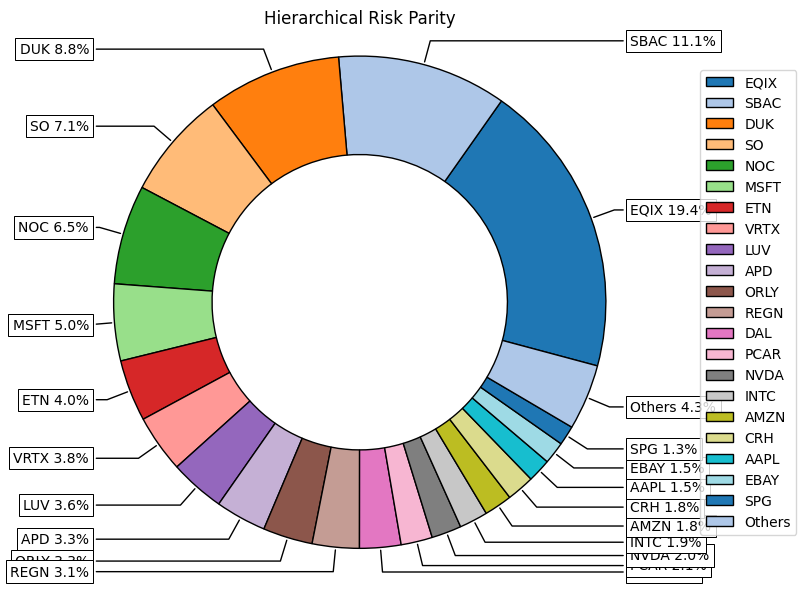

In [140]:
hrp_plot = rp.plot_pie(w=hrp_allocation(portfolio), title='Hierarchical Risk Parity')

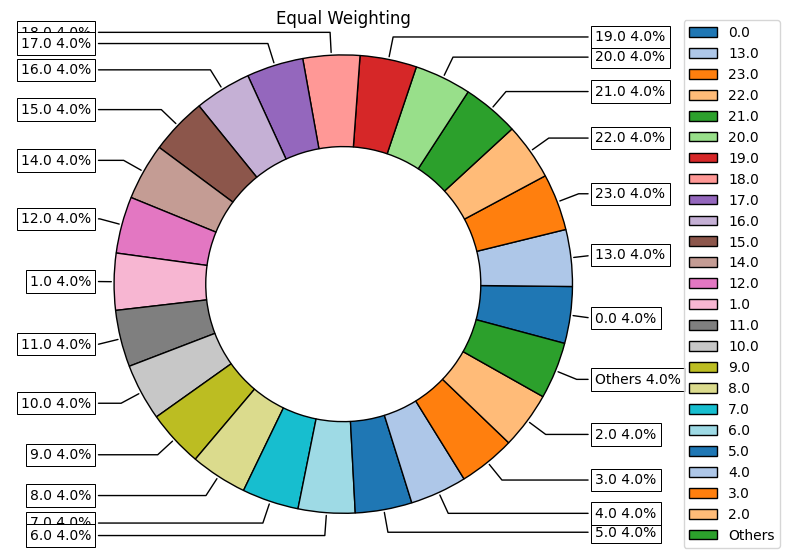

In [141]:
equal_plot = rp.plot_pie(w=pd.DataFrame(equal_allocation(portfolio)), title='Equal Weighting')

You must convert self.cov to a positive definite matrix


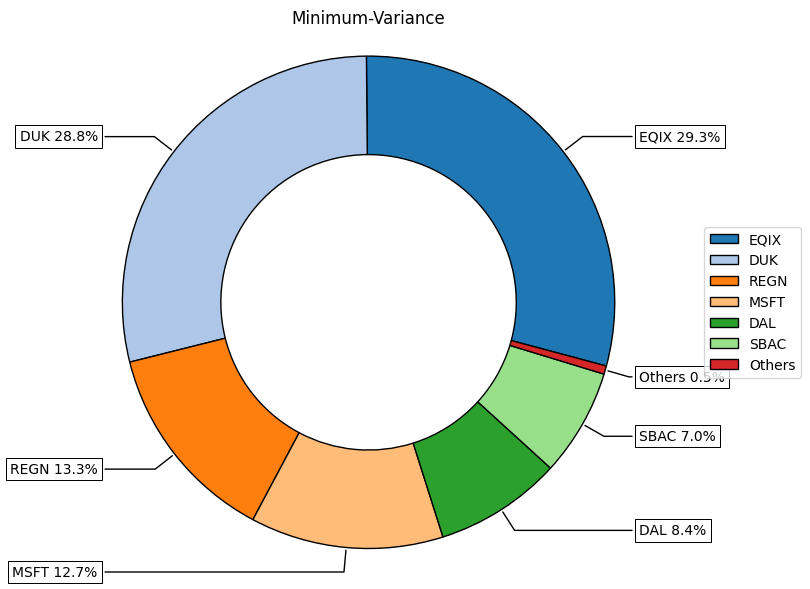

In [142]:
mv_plot = rp.plot_pie(w=minimum_variance_allocation(portfolio), title='Minimum-Variance', nrow=10)


You must convert self.cov to a positive definite matrix


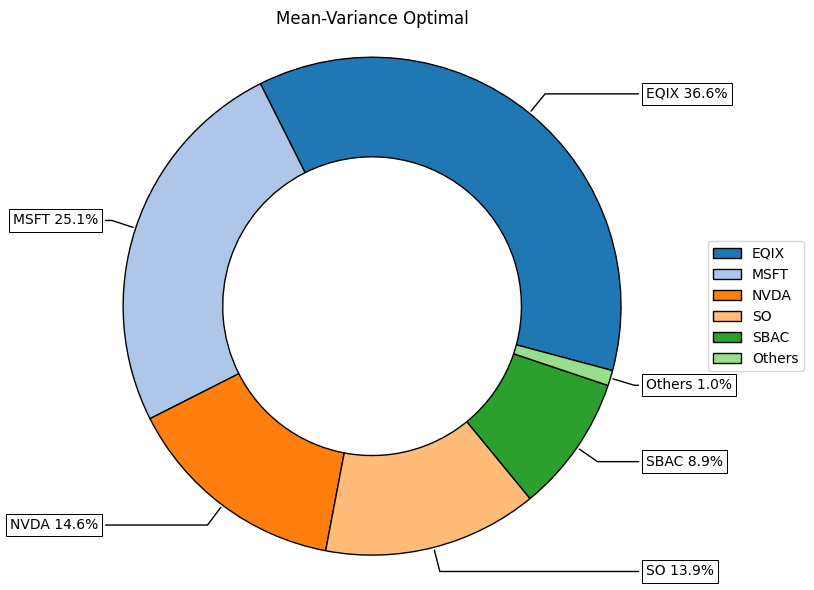

In [143]:
meanv_plot = rp.plot_pie(w=mean_variance_optimal_allocation(portfolio), title='Mean-Variance Optimal')

You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite

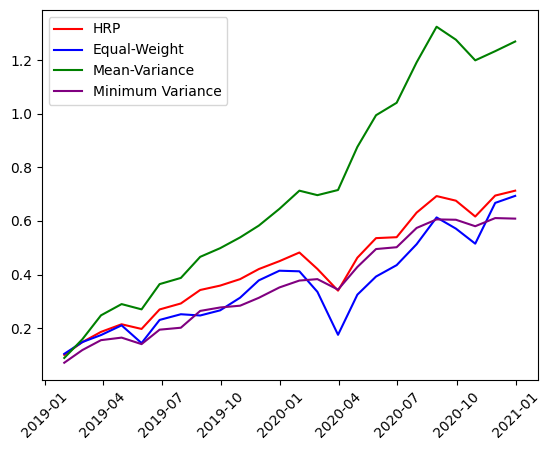

In [7]:
plt.plot(training_returns.index, hrp_return_training_list(portfolio), color="red", label="HRP")
plt.plot(training_returns.index, equal_return_training_list(portfolio), color="blue", label = "Equal-Weight")
plt.plot(training_returns.index, meanv_return_training_list(portfolio), color="green", label = "Mean-Variance")
plt.plot(training_returns.index, mv_return_training_list(portfolio), color="purple", label = "Minimum Variance")
plt.xticks(rotation=45)
plt.legend(loc="upper left");

You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite

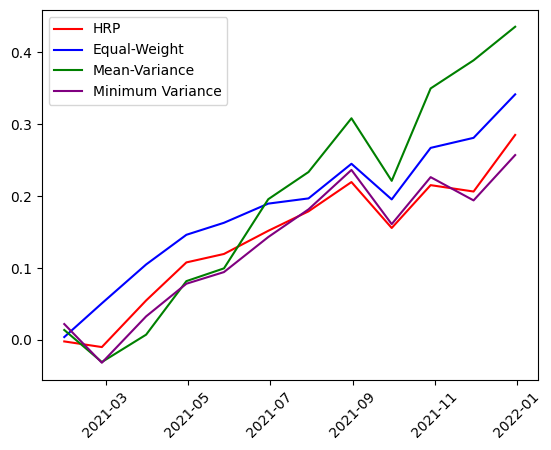

In [145]:
plt.plot(testing_returns.index, hrp_return_testing_list(portfolio), color="red", label="HRP")
plt.plot(testing_returns.index, equal_return_testing_list(portfolio), color="blue", label = "Equal-Weight")
plt.plot(testing_returns.index, meanv_return_testing_list(portfolio), color="green", label = "Mean-Variance")
plt.plot(testing_returns.index, mv_return_testing_list(portfolio), color="purple", label = "Minimum Variance")
plt.xticks(rotation=45)
plt.legend(loc="upper left");

In [8]:
results_df(portfolio)

You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite

Model:               HRP Portfolio          Equal-Weight Portfolio           \
Data Sample:              Training  Testing               Training  Testing   
Performance Measure:                                                          
Mean Return                 2.048%   1.952%                 1.926%   2.254%   
Risk                        3.788%   3.522%                 5.551%   2.795%   
Risk-Adjusted Return        0.5408   0.5544                 0.3471   0.8067   
Cumulative Return          71.277%  28.515%                69.336%  34.163%   

Model:               Minimum Variance Portfolio           \
Data Sample:                           Training  Testing   
Performance Measure:                                       
Mean Return                              1.777%   1.809%   
Risk                                     2.622%   4.334%   
Risk-Adjusted Return                     0.6775   0.4173   
Cumulative Return                       60.857%  25.715%   

Model:               Mean-Variance Optimal Portfolio           
Data Sample:                                Training  Testing  
Performance Measure:                                           
Mean Return                                   3.330%   2.930%  
Risk                                          3.512%   4.970%  
Risk-Adjusted Return                          0.9480   0.5895  
Cumulative Return                            126.91%  43.572%

ticker,AAPL,AMD,AMZN,APD,CRH,CVX,DAL,DUK,EBAY,EQIX,ETN,FITB,INTL,LUV,MET,MSFT,NOC,NVDA,ORLY,PCAR,REGN,SBAC,SO,SPG,VRTX
mthcaldt,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-31,0.054010,0.024858,0.087064,0.015831,-0.067940,-0.110945,-0.046854,0.070387,-0.070618,0.010331,-0.002639,-0.074496,-0.023961,0.018525,-0.024720,0.079455,0.088961,0.004802,-0.073381,-0.061821,-0.099979,0.035562,0.105181,-0.106136,0.036995
2020-02-28,-0.114673,-0.032340,-0.062214,-0.080013,-0.098697,-0.118594,-0.166714,-0.051873,0.036949,-0.024620,-0.039695,-0.142355,-0.044272,-0.159876,-0.133006,-0.045696,-0.118912,0.143007,-0.092046,-0.094674,0.315529,0.062230,-0.134912,-0.061629,-0.013301
2020-03-31,-0.069762,0.000000,0.035021,-0.084969,-0.186368,-0.223698,-0.381530,-0.117993,-0.132217,0.090381,-0.135394,-0.381036,-0.203952,-0.225984,-0.284410,-0.026542,-0.079948,-0.023957,-0.183527,-0.086248,0.098342,0.020198,-0.103048,-0.554274,0.062135
2020-04-30,0.155374,0.151935,0.268900,0.130104,0.122206,0.269666,-0.091833,0.046736,0.325017,0.081064,0.074784,0.258586,0.102041,-0.122438,0.180242,0.136326,0.092943,0.108801,0.283308,0.132504,0.076983,0.073897,0.047839,0.217098,0.055684
2020-05-29,0.085026,0.026914,-0.012785,0.071239,0.067729,0.010632,-0.027017,0.023072,0.147376,0.037447,0.026814,0.037453,0.276527,0.027200,0.011391,0.025352,0.018085,0.214657,0.079981,0.071839,0.165304,0.085169,0.018248,-0.135839,0.146338
2020-06-30,0.147386,-0.022119,0.129567,0.004759,0.066853,-0.026936,0.112654,-0.067033,0.151735,0.006694,0.030389,0.008653,0.078220,0.064798,0.014163,0.110559,-0.082816,0.070597,0.010617,0.013404,0.017689,-0.051603,-0.091467,0.185095,0.008161
2020-07-31,0.165132,0.471773,0.147114,0.187070,0.060624,-0.059285,-0.109804,0.060709,0.053956,0.118439,0.064586,0.030083,NaN,-0.096255,0.036418,0.007371,0.057149,0.117607,0.132118,0.136673,0.013501,0.045717,0.053231,-0.068758,-0.063071
2020-08-31,0.216620,0.172930,0.090461,0.019642,0.019511,0.014600,0.235483,-0.040866,-0.006151,0.008873,0.104207,0.040282,NaN,0.216575,0.028647,0.102768,0.058586,0.259992,-0.024614,0.012526,-0.019207,-0.016043,-0.033080,0.088212,0.026177
2020-09-30,-0.102526,-0.097225,-0.087579,0.023746,-0.021276,-0.142142,-0.008752,0.102315,-0.048923,-0.037542,-0.000686,0.031946,NaN,-0.002129,-0.033541,-0.067397,-0.079157,0.011957,-0.009772,-0.006524,-0.097027,0.040546,0.039095,-0.046721,-0.025079
